In [ ]:
!pip install optimum onnx onnxruntime stable_baselines3 datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.8/425.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.3 MB/s eta 0:00:00


## Load the dataset

### Subtask:
Load the dataset from the Hugging Face URL, specifying the splits that start with `rl_`.


In [ ]:
from datasets import load_dataset

asf_dataset = load_dataset("3nthusiast/ASF", split=[split for split in load_dataset("3nthusiast/ASF").keys() if split.startswith("rl_")])
print(asf_dataset)

README.md:   0%|          | 0.00/973 [00:00<?, ?B/s]

data/llm_train-00000-of-00001.parquet:   0%|          | 0.00/10.8M [00:00<?, ?B/s]

data/llm_dev-00000-of-00001.parquet:   0%|          | 0.00/2.26M [00:00<?, ?B/s]

data/llm_test-00000-of-00001.parquet:   0%|          | 0.00/2.28M [00:00<?, ?B/s]

data/rl_train-00000-of-00001.parquet:   0%|          | 0.00/2.58M [00:00<?, ?B/s]

data/rl_dev-00000-of-00001.parquet:   0%|          | 0.00/545k [00:00<?, ?B/s]

data/rl_test-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating llm_train split:   0%|          | 0/91107 [00:00<?, ? examples/s]

Generating llm_dev split:   0%|          | 0/19523 [00:00<?, ? examples/s]

Generating llm_test split:   0%|          | 0/19524 [00:00<?, ? examples/s]

Generating rl_train split:   0%|          | 0/22777 [00:00<?, ? examples/s]

Generating rl_dev split:   0%|          | 0/4881 [00:00<?, ? examples/s]

Generating rl_test split:   0%|          | 0/4881 [00:00<?, ? examples/s]

[Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 22777
}), Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 4881
}), Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 4881
})]


## Exploring the data

In [ ]:
from datasets import Dataset

for dataset in asf_dataset:
    print(f"Split: {dataset.split}")
    print("Structure:", dataset.features)
    print("Sample data:")
    for i in range(min(5, len(dataset))):
        print(dataset[i])
    print("-" * 20)

Split: rl_train
Structure: {'text': Value('string'), 'label': Value('int64'), '__index_level_0__': Value('int64')}
Sample data:
{'text': 'What is the smallest administrative unit in Germany?', 'label': 0, '__index_level_0__': 114491}
{'text': 'What were Open Firmware-based PCI Macs used as a convenience because of?', 'label': 0, '__index_level_0__': 61428}
{'text': "Was this meant to be a comedy or a serious drama? This film starts with a light-hearted banter between three women. Fine. It moves into a conflict between the women when one of them meets a man. Fine. There are a few antics between them. Fine. But when the plot thickens and finally becomes black I started to wonder whether I had misinterpreted the first part of the movie. It continues in this vein for a while until, in the end, it tries to go back to the original light-hearted banter. But by now it's too late. It's hard to see why these women would still be talking to one another and the finale is unconvincing. Truly a less

In [ ]:
from datasets import Dataset

train_dataset = asf_dataset[0]

safe_examples = train_dataset.filter(lambda example: example["label"] == 0)
malicious_examples = train_dataset.filter(lambda example: example["label"] == 1)

min_samples = min(len(safe_examples), len(malicious_examples))


balanced_safe_examples = safe_examples.select(range(min_samples))
balanced_malicious_examples = malicious_examples.select(range(min_samples))

balanced_train_dataset = Dataset.from_dict({
    col: [item for item in balanced_safe_examples[col]] + [item for item in balanced_malicious_examples[col]]
    for col in balanced_safe_examples.column_names
})



balanced_train_dataset = balanced_train_dataset.shuffle(seed=42)


train_data = [(row["text"], int(row["label"])) for row in balanced_train_dataset]

print("Original training dataset size:", len(train_dataset))
print("Balanced training dataset size:", len(balanced_train_dataset))
print("Number of safe examples in balanced dataset:", len(balanced_safe_examples))
print("Number of malicious examples in balanced dataset:", len(balanced_malicious_examples))

Filter:   0%|          | 0/22777 [00:00<?, ? examples/s]

Filter:   0%|          | 0/22777 [00:00<?, ? examples/s]

Original training dataset size: 22777
Balanced training dataset size: 5340
Number of safe examples in balanced dataset: 2670
Number of malicious examples in balanced dataset: 2670


# Preparing environment for reinforcement learning.


`PromptInjectionEnv` makes use of Perplexity filters and 2 LLM classifiers to find out the best policy with time restriction.

In [ ]:
# @title Training environment implementation

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import time
from datasets import load_dataset
import os

sentinel_model = os.path.join("drive", "MyDrive", "ASF", "models", "sentinel_ai", "final_model.onnx")
tokenizer_path = os.path.join("drive", "MyDrive", "ASF", "models", "sentinel_ai")
perplexity_model = os.path.join("drive", "MyDrive", "ASF", "models", "perplexity_model")
llm_guard_model = os.path.join("drive", "MyDrive", "ASF", "models", "llm_guard")

from drive.MyDrive.ASF.safetychecks import OnnxModelSafetyCheck, PerplexitySafetyCheck, LLMGuardSafetyCheck

class PromptInjectionEnv(gym.Env):
    """
    An RL environment for optimizing a prompt injection detection pipeline.
    """
    def __init__(self, dataset: list, config: dict):
        super().__init__()

        self.dataset = dataset
        self.w_acc_correct = config.get('w_acc_correct', 100.0)
        self.w_acc_incorrect = config.get('w_acc_incorrect', -100.0)
        self.w_time = config.get('w_time', 150)
        self.checkers = [PerplexitySafetyCheck(model_path=perplexity_model), OnnxModelSafetyCheck(model_path=sentinel_model, tokenizer_path=tokenizer_path), LLMGuardSafetyCheck(model_path=llm_guard_model)]
        self.max_steps = len(self.checkers) + 1 # Max steps is the number of checkers + 1 for the final prediction step


        # Actions: 0 = CONTINUE, 1 = PREDICT_SAFE, 2 = PREDICT_MALICIOUS
        self.action_space = spaces.Discrete(3)
        self.episode = 1

        # Observation space: [r1, r2, r3, total_time]
        # Each r is a score from a checker, total_time is the sum of all times
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(len(self.checkers) + 1,), dtype=np.float32
        )

    def _get_obs(self):
        scores = self.state[::2]
        total_time = np.sum(self.state[1::2])
        obs = np.concatenate([scores, [total_time]])
        return obs

    def _get_info(self):
        return {"step": self.current_step, "total_time": np.sum(self.state[1::2])}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.episode += 1
        idx = self.np_random.integers(0, len(self.dataset))
        self.current_prompt, self.ground_truth_label = self.dataset[idx]
        self.current_step = 0

        self.state = np.array([-1.0, 0.0] * len(self.checkers), dtype=np.float32)

        return self._get_obs(), self._get_info()

    def step(self, action: int):
        terminated = False
        truncated = False
        reward = 0.0

        # Action 0: CONTINUE
        if action == 0:
            if self.current_step < len(self.checkers):
                check_function = self.checkers[self.current_step]
                start_time = time.perf_counter()
                score = check_function.check(self.current_prompt)
                time_taken = time.perf_counter() - start_time
                self.state[self.current_step * 2] = score
                self.state[self.current_step * 2 + 1] = time_taken

            if self.current_step >= len(self.checkers):
                truncated = True
                reward += -50.0

        # Action 1: PREDICT_SAFE, Action 2: PREDICT_MALICIOUS
        if action == 1 or action == 2:

            if self.current_step == 0:
              reward += -100.0
            terminated = True
            prediction = 0 if action == 1 else 1
            is_correct = (prediction == self.ground_truth_label)
            accuracy_reward = self.w_acc_correct if is_correct else self.w_acc_incorrect
            total_time = np.sum(self.state[1::2])
            time_penalty = self.w_time * total_time
            reward += accuracy_reward - time_penalty

        self.current_step += 1
        return self._get_obs(), reward, terminated, truncated, self._get_info()

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/registration.py:162: OnnxExporterWarning: Symbolic function 'aten::scaled_dot_product_attention' already registered for opset 14. Replacing the existing function with new function. This is unexpected. Please report it on https://github.com/pytorch/pytorch/issues.
  warnings.warn(


# Model training

We are using PPO combined with Multilayer perceptron architecture.

In [ ]:
# @title Training

from stable_baselines3 import PPO
import torch

device = torch.device("cpu")

train_data = [(row["text"], int(row["label"])) for row in balanced_train_dataset]

config = {}
env = PromptInjectionEnv(dataset=train_data, config=config)
model = PPO("MlpPolicy", env, verbose=1, device=device)
model.learn(total_timesteps=40000)
model.save("drive/MyDrive/ASF/models/ppo_prompt_injection_v3")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
Device set to use cpu


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.56     |
|    ep_rew_mean     | -71.2    |
| time/              |          |
|    fps             | 36       |
|    iterations      | 1        |
|    time_elapsed    | 55       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.78        |
|    ep_rew_mean          | -68.1       |
| time/                   |             |
|    fps                  | 34          |
|    iterations           | 2           |
|    time_elapsed         | 118         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.026947891 |
|    clip_fraction        | 0.265       |
|    clip_range           | 0.2         |
|    entropy_loss   

Evaluating PPO model on dev set...


Device set to use cpu


IntProgress(value=0, description='Dev Evaluation:', max=4881)

Dev accuracy: 0.971 (4741/4881)
Average total time per episode on dev set: 0.0518 seconds
Total measured time per RL pass on dev set: 0.0547 seconds
Average total amount of steps per episode on dev set: 2.9332104077033394 steps
Long runs count: 4881
------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


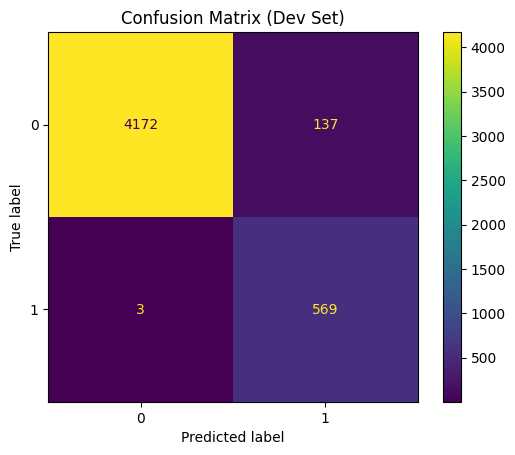

In [ ]:
# @title Evaluation

from stable_baselines3 import PPO
import torch
from datasets import load_dataset
import time
from ipywidgets import IntProgress
from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

device = torch.device("cpu")
model = PPO.load("drive/MyDrive/ASF/models/ppo_prompt_injection_v2", device=device)

asf_dataset = load_dataset("3nthusiast/ASF", split=[split for split in load_dataset("3nthusiast/ASF").keys() if split.startswith("rl_")])
dev_data = [(row["text"], int(row["label"])) for row in asf_dataset[1]]
test_data = [(row["text"], int(row["label"])) for row in asf_dataset[2]]

config = {}


print("Evaluating PPO model on dev set...")
dev_env = PromptInjectionEnv(dataset=dev_data, config=config)

num_episodes_dev = len(dev_data)
correct = 0
total = 0
total_time = 0.0
dev_predictions = []
dev_true_labels = []

dev_progress_bar = IntProgress(min=0, max=num_episodes_dev, description='Dev Evaluation:')
display(dev_progress_bar)
total_steps = 0
long_runs = 0
total_measured_time = 0.0
for i in range(num_episodes_dev):
    steps = 0
    obs, info = dev_env.reset()
    done = False
    start_time = time.perf_counter()
    while not done:
        steps += 1
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = dev_env.step(action)
        done = terminated or truncated
    long_runs += 1
    end_time = time.perf_counter()
    # 1: PREDICT_SAFE, 2: PREDICT_MALICIOUS
    pred = 0 if action == 1 else 1
    label = dev_env.ground_truth_label
    dev_predictions.append(pred)
    dev_true_labels.append(label)
    if pred == label:
        correct += 1
    total += 1
    total_steps += steps
    total_measured_time = total_measured_time + (end_time - start_time)
    total_time += info["total_time"]
    dev_progress_bar.value = i + 1

print(f"Dev accuracy: {correct/total:.3f} ({correct}/{total})")
print(f"Average total time per episode on dev set: {total_time/total:.4f} seconds")
print(f"Total measured time per RL pass on dev set: {total_measured_time/total:.4f} seconds")
print(f"Average total amount of steps per episode on dev set: {total_steps/total} steps")
print(f"Long runs count: {long_runs}")
print("-" * 30)

cm_dev = confusion_matrix(dev_true_labels, dev_predictions)
disp_dev = ConfusionMatrixDisplay(confusion_matrix=cm_dev, display_labels=[0, 1])
disp_dev.plot()
plt.title("Confusion Matrix (Dev Set)")
plt.show()